# Preprocessing Pipeline

1. Load and normalize audio to fixed length (4 seconds)
2. Extract mel spectrograms as features
3. Save to `data/interim/` for review


In [1]:
import librosa
import numpy as np
from pathlib import Path
import pickle

# Paths
RAW_DIR = Path("../data/raw")
INTERIM_DIR = Path("../data/interim")
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

# Audio settings
SAMPLE_RATE = 22050
DURATION = 4  # seconds
N_SAMPLES = SAMPLE_RATE * DURATION

# Mel spectrogram settings
N_MELS = 128
HOP_LENGTH = 512

print(f"Target duration: {DURATION}s ({N_SAMPLES} samples at {SAMPLE_RATE}Hz)")


Target duration: 4s (88200 samples at 22050Hz)


## 1. Load and Pad/Truncate Audio


In [2]:
def load_and_pad(file_path, sr=SAMPLE_RATE, n_samples=N_SAMPLES):
    """Load audio, resample, and pad/truncate to fixed length."""
    y, _ = librosa.load(file_path, sr=sr)
    
    # Pad if too short
    if len(y) < n_samples:
        y = np.pad(y, (0, n_samples - len(y)), mode='constant')
    # Truncate if too long
    else:
        y = y[:n_samples]
    
    return y

# Test on one file
test_file = next(RAW_DIR.glob("*/*.mp3"))
y = load_and_pad(test_file)
print(f"Loaded: {test_file.name}")
print(f"Shape: {y.shape} (expected: {N_SAMPLES})")


Loaded: car_extcoll0163.mp3
Shape: (88200,) (expected: 88200)


## 2. Extract Mel Spectrograms


In [3]:
def extract_mel_spectrogram(y, sr=SAMPLE_RATE, n_mels=N_MELS, hop_length=HOP_LENGTH):
    """Extract log mel spectrogram from audio."""
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

# Test
mel = extract_mel_spectrogram(y)
print(f"Mel spectrogram shape: {mel.shape}")
print(f"  -> {mel.shape[0]} mel bands × {mel.shape[1]} time frames")


Mel spectrogram shape: (128, 173)
  -> 128 mel bands × 173 time frames


## 3. Process All Files


In [4]:
# Get all categories
categories = sorted([d.name for d in RAW_DIR.iterdir() if d.is_dir()])
print(f"Categories: {categories}")

# Create label mapping
label_to_idx = {cat: i for i, cat in enumerate(categories)}
idx_to_label = {i: cat for cat, i in label_to_idx.items()}
print(f"Label mapping: {label_to_idx}")


Categories: ['Angry', 'Defense', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning']
Label mapping: {'Angry': 0, 'Defense': 1, 'Fighting': 2, 'Happy': 3, 'HuntingMind': 4, 'Mating': 5, 'MotherCall': 6, 'Paining': 7, 'Resting': 8, 'Warning': 9}


In [5]:
# Process all audio files
X = []  # mel spectrograms
y = []  # labels
filenames = []

for cat in categories:
    for audio_file in sorted((RAW_DIR / cat).glob("*.mp3")):
        try:
            # Load and pad
            audio = load_and_pad(audio_file)
            # Extract mel spectrogram
            mel = extract_mel_spectrogram(audio)
            
            X.append(mel)
            y.append(label_to_idx[cat])
            filenames.append(f"{cat}/{audio_file.name}")
        except Exception as e:
            print(f"Error processing {audio_file}: {e}")

X = np.array(X)
y = np.array(y)

print(f"Processed {len(X)} files")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Processed 100 files
X shape: (100, 128, 173)
y shape: (100,)


## 4. Quick Verification


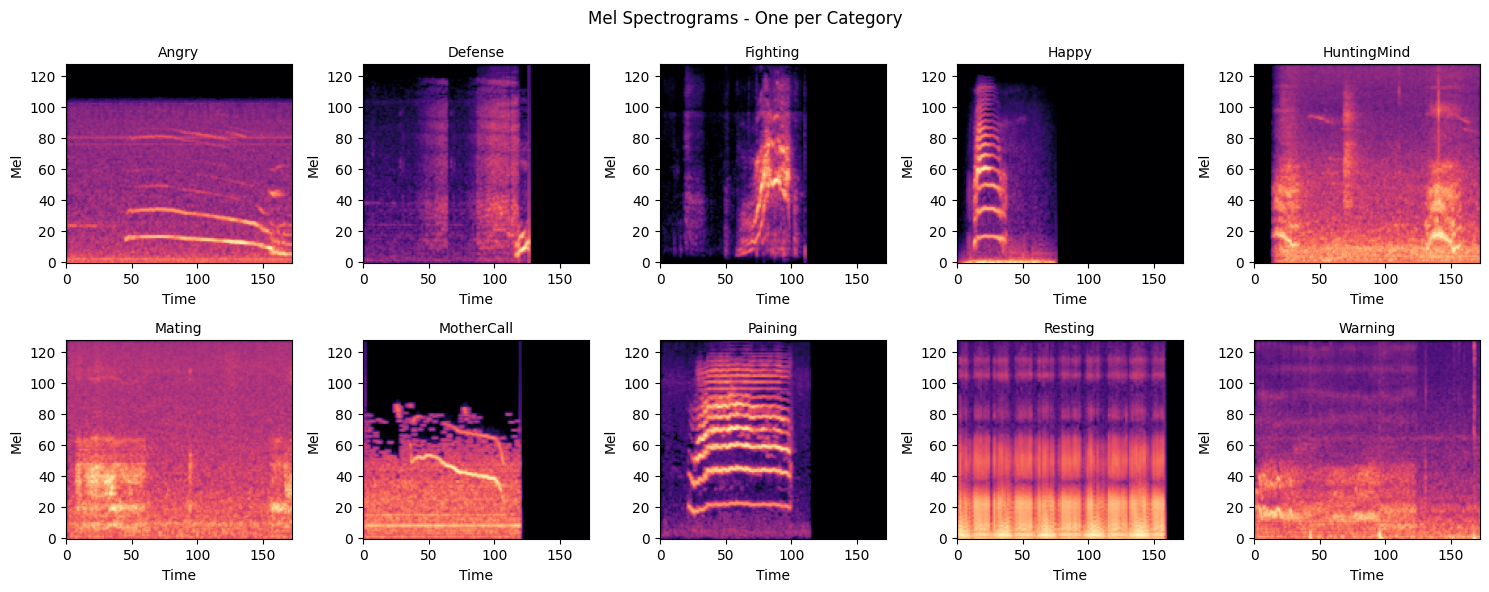

In [6]:
import matplotlib.pyplot as plt

# Show a few samples from different categories
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

# Pick one sample from each category
for i, cat in enumerate(categories):
    idx = np.where(y == i)[0][0]  # first sample of this category
    axes[i].imshow(X[idx], aspect='auto', origin='lower', cmap='magma')
    axes[i].set_title(cat, fontsize=10)
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Mel")

plt.suptitle("Mel Spectrograms - One per Category", fontsize=12)
plt.tight_layout()
plt.show()


## 5. Save to Interim


In [7]:
# Save as numpy arrays
np.save(INTERIM_DIR / "X.npy", X)
np.save(INTERIM_DIR / "y.npy", y)

# Save metadata
metadata = {
    "label_to_idx": label_to_idx,
    "idx_to_label": idx_to_label,
    "filenames": filenames,
    "sample_rate": SAMPLE_RATE,
    "duration": DURATION,
    "n_mels": N_MELS,
    "hop_length": HOP_LENGTH,
}

with open(INTERIM_DIR / "metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print(f"Saved to {INTERIM_DIR}/")
print(f"  - X.npy: {X.shape}")
print(f"  - y.npy: {y.shape}")
print(f"  - metadata.pkl")


Saved to ../data/interim/
  - X.npy: (100, 128, 173)
  - y.npy: (100,)
  - metadata.pkl


In [8]:
# Summary stats
print("=== Preprocessing Complete ===")
print(f"Total samples: {len(X)}")
print(f"Feature shape: {X.shape[1:]} (mel bands × time frames)")
print(f"Classes: {len(categories)}")
print(f"\nValue range: [{X.min():.1f}, {X.max():.1f}] dB")
print(f"\nReady for training! Move to data/processed/ when satisfied.")


=== Preprocessing Complete ===
Total samples: 100
Feature shape: (128, 173) (mel bands × time frames)
Classes: 10

Value range: [-80.0, 0.0] dB

Ready for training! Move to data/processed/ when satisfied.
